In [ ]:
#calculates insurance payouts for emodis and smodis
#calculates number of payouts that were triggered at the same time
#makes time series graphs of payouts and index values for a selected UAI
#author: Sara Miller

!pip install --upgrade pip --quiet

# try to import packages needed
try:
  import ee
  import folium
  from ee.ee_exception import EEException
  
  from google.colab import auth
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from oauth2client.client import GoogleCredentials


# if it doesn't work, intstall the packages...
except ImportError:
  !pip install -q earthengine-api
  !pip install -q folium
  !pip install -q bokeh
  
  # ...then import
  import ee
  import folium
  from ee.ee_exception import EEException


# import Python packages for utility
import numpy as np
import pandas as pd
import math
import datetime
from itertools import groupby
import geopandas as gpd
from shapely.geometry import shape
import matplotlib.pyplot as plt
from google.colab import files

     |████████████████████████████████| 1.4MB 4.7MB/s 
     |████████████████████████████████| 153kB 4.9MB/s 


/usr/local/lib/python2.7/dist-packages/folium/__init__.py:59: UserWarning: This version of folium is the last to support Python 2. Transition to Python 3 to be able to receive updates and fixes. Check out https://python3statement.org/ for more info.
  UserWarning


In [ ]:
# try to initialize Earth Engine session
try:
  ee.Initialize()

# if it doesn't work, then authorize an account for Earth Engine to connect to...
except EEException:
  !earthengine authenticate --quiet

  authCode = raw_input("Authorization code:")

  !earthengine authenticate --authorization-code=$authCode
  
  # ...then initialize session
  ee.Initialize()

In [ ]:
uai = ee.FeatureCollection('users/sem0029/KLIP_BORANA_CLEAN_2017')

#function to rescale NDVI from 0-200 to -1-1, from sMODIS export code
def rescaleNDVI(img):
  ndvi = img.subtract(100).divide(100).rename('ndvi')
  return ndvi.updateMask(ndvi.gt(-1).And(ndvi.lt(1))).set('system:time_start',img.get('system:time_start'))

#function to mask pixels with limited temporal variability using eMODIS_FEWS_Kenya_dia_BASIS
def imgmask(img):
  mask1 = ee.Image('users/sem0029/mask1').eq(0)
  return img.updateMask(mask1)

#get sMODIS and eMODIS, mask pixels and rescale NDVI
smodis = ee.ImageCollection('projects/servir-e-sa/sMODIS').map(imgmask).map(rescaleNDVI)
emodis = ee.ImageCollection('users/servirscience/eModis').map(imgmask).map(rescaleNDVI)

#function to convert feature class to pandas dataframe
#from https://gis.stackexchange.com/questions/257727/iterate-over-imagecollection-returning-pandas-dataframe-using-earth-engine-pyt?noredirect=1&lq=1
def fc2df(fc):
  # Convert a FeatureCollection into a pandas DataFrame
  # Features is a list of dict with the output
  features = fc.getInfo()['features']

  dictarr = []

  for f in features:
    # Store all attributes in a dict
    attr = f['properties']
    # and treat geometry separately
    attr['geometry'] = f['geometry']  # GeoJSON Feature!
    # attr['geometrytype'] = f['geometry']['type']
    dictarr.append(attr)

  df = gpd.GeoDataFrame(dictarr)
  # Convert GeoJSON features to shape
  df['geometry'] = map(lambda s: shape(s), df.geometry)    
  return df

In [ ]:
#calculate sMODIS long rains payouts
yr = 2003
m = 3

#set up empty dataframes 
smodislrdf = gpd.GeoDataFrame()
dictarr = []

for yr in range(2003, 2017):
  for m in range(3, 7):
    #calculate average monthly NDVI
    sfilter = smodis.filter(ee.Filter.calendarRange(yr, yr, 'year')).filter(ee.Filter.calendarRange(m, m, 'month'))
     
    savg = sfilter.reduce(ee.Reducer.mean())
    
    #average monthly NDVI per UAI
    smonthlyuai = savg.reduceRegions(collection=uai, reducer=ee.Reducer.mean(), scale=250)
      

    #convert the results from Reduce.Regions into a dataframe
    sdf = fc2df(smonthlyuai)
    
    
    #add columns to the dataframe
    smodislrdf['avg'+str(yr)+str(m)] = sdf['mean']
    #set index of the dataframe to UAI gridcode and set geometry
    if (yr == 2016)& (m == 6):
      smodislrdf['gridcode'] = sdf['gridcode']
      smodislrdf.set_index('gridcode', inplace=True, drop=True)
      smodislrdf['geometry'] = map(lambda s: shape(s), sdf.geometry)


  #calculate cumulative seasonal NDVI
  smodislrdf['cm'+str(yr)] = smodislrdf['avg'+str(yr)+'3']+smodislrdf['avg'+str(yr)+'4']+smodislrdf['avg'+str(yr)+'5']+smodislrdf['avg'+str(yr)+'6']


#find mean and standard deviation of NDVI from 2001-2016 per UAI
columnlist = ['cm2003', 'cm2004', 'cm2005', 'cm2006', 'cm2007', 'cm2008', 'cm2009', 'cm2010', 'cm2011', 'cm2012', 'cm2013', 'cm2014', 'cm2015', 'cm2016']
smodislrdf['meanndvi'] = smodislrdf[columnlist].mean(axis = 1)
smodislrdf['stddev'] = smodislrdf[columnlist].std(axis = 1)

for yr in range(2003, 2017):
  #calculate index values for each rain period/year/uai
  smodislrdf['index'+str(yr)] = (smodislrdf['cm'+str(yr)] - smodislrdf['meanndvi']) / smodislrdf['stddev']

  
#calculate thresholds
columnlist1 = ['index2003', 'index2004', 'index2005', 'index2006', 'index2007', 'index2008', 'index2009', 'index2010', 'index2011', 'index2012', 'index2013', 'index2014', 'index2015', 'index2016']
smodislrdf['trigger'] = smodislrdf[columnlist1].quantile(0.2, axis = 1)
smodislrdf['exit'] = smodislrdf[columnlist1].quantile(0.01, axis = 1)


for yr in range(2003, 2017):
  #calculate percent payouts
  smodislrdf['payout'+str(yr)] = (smodislrdf['trigger'] - smodislrdf['index'+str(yr)]) / (smodislrdf['trigger'] - smodislrdf['exit']) * 100
  smodislrdf['payout'+str(yr)] = np.where(smodislrdf['payout'+str(yr)]>100, 100, smodislrdf['payout'+str(yr)])
  smodislrdf['payout'+str(yr)] = np.where((smodislrdf['payout'+str(yr)]<5)&(smodislrdf['payout'+str(yr)]>0), 5, smodislrdf['payout'+str(yr)])
  smodislrdf['payout'+str(yr)] = np.where((smodislrdf['payout'+str(yr)]<0), 0, smodislrdf['payout'+str(yr)])

#download csv  
#smodislrdf.to_csv('smodislrdf.csv')
#files.download('smodislrdf.csv')


In [ ]:
#calculate eMODIS long rains payouts
yr = 2003
m = 3

#set up empty dataframes 
emodislrdf = gpd.GeoDataFrame()
dictarr = []

for yr in range(2003, 2017):
  for m in range(3, 7):
    #calculate average monthly NDVI
    efilter = emodis.filter(ee.Filter.calendarRange(yr, yr, 'year')).filter(ee.Filter.calendarRange(m, m, 'month'))
     
    eavg = efilter.reduce(ee.Reducer.mean())
    
    #average monthly NDVI per UAI
    emonthlyuai = eavg.reduceRegions(collection=uai, reducer=ee.Reducer.mean(), scale=250)
      

    #convert the results from Reduce.Regions into a dataframe
    edf = fc2df(emonthlyuai)
    
    
    #try to add columns to the dataframe
    emodislrdf['avg'+str(yr)+str(m)] = edf['mean']
    #set index of the dataframe to UAI gridcode
    if (yr == 2016)& (m == 6):
      emodislrdf['gridcode'] = edf['gridcode']
      emodislrdf.set_index('gridcode', inplace=True, drop=True)
      emodislrdf['geometry'] = map(lambda s: shape(s), edf.geometry)

    
  #calculate cumulative seasonal NDVI
  emodislrdf['cm'+str(yr)] = emodislrdf['avg'+str(yr)+'3']+emodislrdf['avg'+str(yr)+'4']+emodislrdf['avg'+str(yr)+'5']+emodislrdf['avg'+str(yr)+'6']


#find mean and standard deviation of NDVI from 2001-2016 per UAI
columnlist = ['cm2003', 'cm2004', 'cm2005', 'cm2006', 'cm2007', 'cm2008', 'cm2009', 'cm2010', 'cm2011', 'cm2012', 'cm2013', 'cm2014', 'cm2015', 'cm2016']
emodislrdf['meanndvi'] = emodislrdf[columnlist].mean(axis = 1)
emodislrdf['stddev'] = emodislrdf[columnlist].std(axis = 1)

for yr in range(2003, 2017):
  #calculate index values for each rain period/year/uai
  emodislrdf['index'+str(yr)] = (emodislrdf['cm'+str(yr)] - emodislrdf['meanndvi']) / emodislrdf['stddev']

  
#calculate thresholds
columnlist1 = ['index2003', 'index2004', 'index2005', 'index2006', 'index2007', 'index2008', 'index2009', 'index2010', 'index2011', 'index2012', 'index2013', 'index2014', 'index2015', 'index2016']
emodislrdf['trigger'] = emodislrdf[columnlist1].quantile(0.2, axis = 1)
emodislrdf['exit'] = emodislrdf[columnlist1].quantile(0.01, axis = 1)


for yr in range(2003, 2017):
  #calculate percent payouts
  emodislrdf['payout'+str(yr)] = (emodislrdf['trigger'] - emodislrdf['index'+str(yr)]) / (emodislrdf['trigger'] - emodislrdf['exit']) * 100
  emodislrdf['payout'+str(yr)] = np.where(emodislrdf['payout'+str(yr)]>100, 100, emodislrdf['payout'+str(yr)])
  emodislrdf['payout'+str(yr)] = np.where((emodislrdf['payout'+str(yr)]<5)&(emodislrdf['payout'+str(yr)]>0), 5, emodislrdf['payout'+str(yr)])
  emodislrdf['payout'+str(yr)] = np.where((emodislrdf['payout'+str(yr)]<0), 0, emodislrdf['payout'+str(yr)])

#download csv  
#emodislrdf.to_csv('emodislrdf.csv')
#files.download('emodislrdf.csv')

In [ ]:
#calculate sMODIS short rains payouts
yr = 2003
m = 10

#set up empty dataframes 
smodissrdf = gpd.GeoDataFrame()
dictarr = []

for yr in range(2003, 2017):
  for m in range(10, 13):
    #calculate average monthly NDVI
    sfilter = smodis.filter(ee.Filter.calendarRange(yr, yr, 'year')).filter(ee.Filter.calendarRange(m, m, 'month'))
     
    savg = sfilter.reduce(ee.Reducer.mean())
    
    #average monthly NDVI per UAI
    smonthlyuai = savg.reduceRegions(collection=uai, reducer=ee.Reducer.mean(), scale=250)
      

    #convert the results from Reduce.Regions into a dataframe
    sdf = fc2df(smonthlyuai)
    
    
    #try to add columns to the dataframe
    smodissrdf['avg'+str(yr)+str(m)] = sdf['mean']
    #set index of the dataframe to UAI gridcode
    if (yr == 2016)& (m == 12):
      smodissrdf['gridcode'] = sdf['gridcode']
      smodissrdf.set_index('gridcode', inplace=True, drop=True)
      smodissrdf['geometry'] = map(lambda s: shape(s), sdf.geometry)

    
  #calculate cumulative seasonal NDVI
  smodissrdf['cm'+str(yr)] = smodissrdf['avg'+str(yr)+'10']+smodissrdf['avg'+str(yr)+'11']+smodissrdf['avg'+str(yr)+'12']


#find mean and standard deviation of NDVI from 2001-2016 per UAI
columnlist = ['cm2003', 'cm2004', 'cm2005', 'cm2006', 'cm2007', 'cm2008', 'cm2009', 'cm2010', 'cm2011', 'cm2012', 'cm2013', 'cm2014', 'cm2015', 'cm2016']
smodissrdf['meanndvi'] = smodissrdf[columnlist].mean(axis = 1)
smodissrdf['stddev'] = smodissrdf[columnlist].std(axis = 1)

for yr in range(2003, 2017):
  #calculate index values for each rain period/year/uai
  smodissrdf['index'+str(yr)] = (smodissrdf['cm'+str(yr)] - smodissrdf['meanndvi']) / smodissrdf['stddev']

  
#calculate thresholds
columnlist1 = ['index2003', 'index2004', 'index2005', 'index2006', 'index2007', 'index2008', 'index2009', 'index2010', 'index2011', 'index2012', 'index2013', 'index2014', 'index2015', 'index2016']
smodissrdf['trigger'] = smodissrdf[columnlist1].quantile(0.2, axis = 1)
smodissrdf['exit'] = smodissrdf[columnlist1].quantile(0.01, axis = 1)


for yr in range(2003, 2017):
  #calculate percent payouts
  smodissrdf['payout'+str(yr)] = (smodissrdf['trigger'] - smodissrdf['index'+str(yr)]) / (smodissrdf['trigger'] - smodissrdf['exit']) * 100
  smodissrdf['payout'+str(yr)] = np.where(smodissrdf['payout'+str(yr)]>100, 100, smodissrdf['payout'+str(yr)])
  smodissrdf['payout'+str(yr)] = np.where((smodissrdf['payout'+str(yr)]<5)&(smodissrdf['payout'+str(yr)]>0), 5, smodissrdf['payout'+str(yr)])
  smodissrdf['payout'+str(yr)] = np.where((smodissrdf['payout'+str(yr)]<0), 0, smodissrdf['payout'+str(yr)])

  
#download csv  
#smodissrdf.to_csv('smodissrdf.csv')
#files.download('smodissrdf.csv')  

In [ ]:
#calculate eMODIS short rains payouts
yr = 2003
m = 10

#set up empty dataframes 
emodissrdf = gpd.GeoDataFrame()
dictarr = []

for yr in range(2003, 2017):
  for m in range(10, 13):
    #calculate average monthly NDVI
    efilter = emodis.filter(ee.Filter.calendarRange(yr, yr, 'year')).filter(ee.Filter.calendarRange(m, m, 'month'))
     
    eavg = efilter.reduce(ee.Reducer.mean())
    
    #average monthly NDVI per UAI
    emonthlyuai = eavg.reduceRegions(collection=uai, reducer=ee.Reducer.mean(), scale=250)
      

    #convert the results from Reduce.Regions into a dataframe
    edf = fc2df(emonthlyuai)
    
    
    #try to add columns to the dataframe
    emodissrdf['avg'+str(yr)+str(m)] = edf['mean']
    #set index of the dataframe to UAI gridcode
    if (yr == 2016)& (m == 12):
      emodissrdf['gridcode'] = edf['gridcode']
      emodissrdf.set_index('gridcode', inplace=True, drop=True)
      emodissrdf['geometry'] = map(lambda s: shape(s), edf.geometry)

    
  #calculate cumulative seasonal NDVI
  emodissrdf['cm'+str(yr)] = emodissrdf['avg'+str(yr)+'10']+emodissrdf['avg'+str(yr)+'11']+emodissrdf['avg'+str(yr)+'12']


#find mean and standard deviation of NDVI from 2001-2016 per UAI
columnlist = ['cm2003', 'cm2004', 'cm2005', 'cm2006', 'cm2007', 'cm2008', 'cm2009', 'cm2010', 'cm2011', 'cm2012', 'cm2013', 'cm2014', 'cm2015', 'cm2016']
emodissrdf['meanndvi'] = emodissrdf[columnlist].mean(axis = 1)
emodissrdf['stddev'] = emodissrdf[columnlist].std(axis = 1)

for yr in range(2003, 2017):
  #calculate index values for each rain period/year/uai
  emodissrdf['index'+str(yr)] = (emodissrdf['cm'+str(yr)] - emodissrdf['meanndvi']) / emodissrdf['stddev']

  
#calculate thresholds
columnlist1 = ['index2003', 'index2004', 'index2005', 'index2006', 'index2007', 'index2008', 'index2009', 'index2010', 'index2011', 'index2012', 'index2013', 'index2014', 'index2015', 'index2016']
emodissrdf['trigger'] = emodissrdf[columnlist1].quantile(0.2, axis = 1)
emodissrdf['exit'] = emodissrdf[columnlist1].quantile(0.01, axis = 1)


for yr in range(2003, 2017):
  #calculate percent payouts
  emodissrdf['payout'+str(yr)] = (emodissrdf['trigger'] - emodissrdf['index'+str(yr)]) / (emodissrdf['trigger'] - emodissrdf['exit']) * 100
  emodissrdf['payout'+str(yr)] = np.where(emodissrdf['payout'+str(yr)]>100, 100, emodissrdf['payout'+str(yr)])
  emodissrdf['payout'+str(yr)] = np.where((emodissrdf['payout'+str(yr)]<5)&(emodissrdf['payout'+str(yr)]>0), 5, emodissrdf['payout'+str(yr)])
  emodissrdf['payout'+str(yr)] = np.where((emodissrdf['payout'+str(yr)]<0), 0, emodissrdf['payout'+str(yr)])

  
#download csv  
emodissrdf.to_csv('emodissrdf.csv')
files.download('emodissrdf.csv')  
  

Number of UAIs with 0, 2, 4, and 6 payouts triggered at different times for long rains:
0    94
2    74
4     4
dtype: int64
Number of UAIs with 0, 2, 4, and 6 payouts triggered at different times for short rains:
0    123
2     47
4      1
6      1
dtype: int64


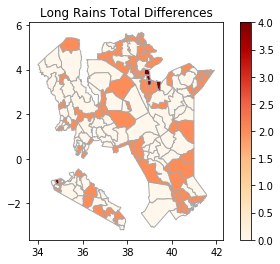

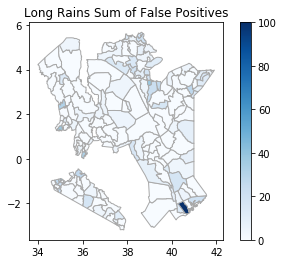

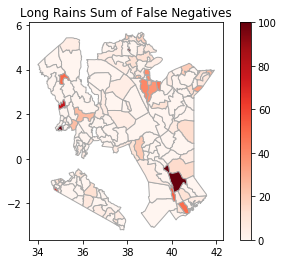

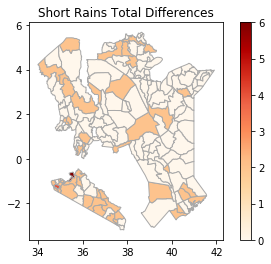

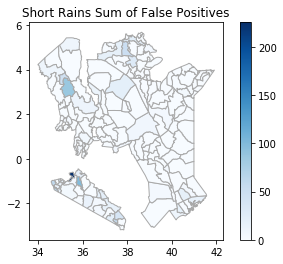

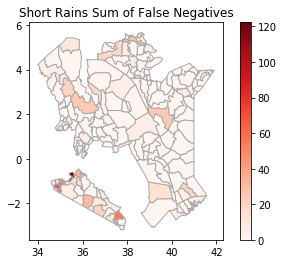

In [ ]:
#compare payouts

lrcomparison = gpd.GeoDataFrame()

for yr in range(2003, 2017):
  lrcomparison['difference'+str(yr)] = np.where(((smodislrdf['payout'+str(yr)]==0)&(emodislrdf['payout'+str(yr)]==0)) | ((smodislrdf['payout'+str(yr)]!=0)&(emodislrdf['payout'+str(yr)]!=0)), 0, 1)
  #when one product triggers a payout and the other doesn't it assigns a 1 to that UAI for the year
  if yr ==2003:
    lrcomparison.index = emodislrdf.index
  lrcomparison['falsepos'+str(yr)] = np.where((lrcomparison['difference'+str(yr)]==1)&(smodislrdf['payout'+str(yr)]>emodislrdf['payout'+str(yr)]), smodislrdf['payout'+str(yr)]-emodislrdf['payout'+str(yr)], 0)
  #gets how far off the payouts are when one product triggered a payout and the other didn't
  lrcomparison['falseneg'+str(yr)] = np.where((lrcomparison['difference'+str(yr)]==1)&(smodislrdf['payout'+str(yr)]<emodislrdf['payout'+str(yr)]), emodislrdf['payout'+str(yr)]-smodislrdf['payout'+str(yr)], 0)

  
#sum number of differences and set index to gridcode
differencecolumns = ['difference2003', 'difference2004', 'difference2005', 'difference2006', 'difference2007', 'difference2008', 'difference2009', 'difference2010', 'difference2011', 'difference2012', 'difference2013', 'difference2014', 'difference2015', 'difference2016']
lrcomparison['totaldifference'] = lrcomparison[differencecolumns].sum(axis = 1)


#sum of false positives and negatives
#false positives are when smodis triggered a payout and emodis did not
#false negatives are when emodis triggered a payout and smodis did not
columnlist2 = ['falsepos2003', 'falsepos2004', 'falsepos2005', 'falsepos2006', 'falsepos2007', 'falsepos2008', 'falsepos2009', 'falsepos2010', 'falsepos2011', 'falsepos2012', 'falsepos2013', 'falsepos2014', 'falsepos2015', 'falsepos2016']
columnlist3 = ['falseneg2003', 'falseneg2004', 'falseneg2005', 'falseneg2006', 'falseneg2007', 'falseneg2008', 'falseneg2009', 'falseneg2010', 'falseneg2011', 'falseneg2012', 'falseneg2013', 'falseneg2014', 'falseneg2015', 'falseneg2016']
lrcomparison['sumfalsepos'] = lrcomparison[columnlist2].sum(axis=1) #sum only the positive values
lrcomparison['sumfalseneg'] = lrcomparison[columnlist3].sum(axis=1) #sum only negatives

#plot total differences, sum of false positives, and sum of false negatives
lrcomparison['geometry'] = map(lambda s: shape(s), emodislrdf.geometry)
lrcomparison.plot(column='totaldifference', cmap='OrRd', legend=True, edgecolor='#a9a9a9').set_title('Long Rains Total Differences')
lrcomparison.plot(column='sumfalsepos', cmap='Blues', legend=True, edgecolor='#a9a9a9').set_title('Long Rains Sum of False Positives')
lrcomparison.plot(column='sumfalseneg', cmap='Reds', legend=True, edgecolor='#a9a9a9').set_title('Long Rains Sum of False Negatives')



#do the same for short rains
srcomparison = gpd.GeoDataFrame()

for yr in range(2003, 2017):
  srcomparison['difference'+str(yr)] = np.where(((smodissrdf['payout'+str(yr)]==0)&(emodissrdf['payout'+str(yr)]==0)) | ((smodissrdf['payout'+str(yr)]!=0)&(emodissrdf['payout'+str(yr)]!=0)), 0, 1)
  if yr ==2003:
    srcomparison.index = emodissrdf.index
  srcomparison['falsepos'+str(yr)] = np.where((srcomparison['difference'+str(yr)]==1)&(smodissrdf['payout'+str(yr)]>emodissrdf['payout'+str(yr)]), smodissrdf['payout'+str(yr)]-emodissrdf['payout'+str(yr)], 0)
  #gets how far off the payouts are when one product triggered a payout and the other didn't
  srcomparison['falseneg'+str(yr)] = np.where((srcomparison['difference'+str(yr)]==1)&(smodissrdf['payout'+str(yr)]<emodissrdf['payout'+str(yr)]), emodissrdf['payout'+str(yr)]-smodissrdf['payout'+str(yr)], 0)

srcomparison['totaldifference'] = srcomparison[differencecolumns].sum(axis = 1)
srcomparison['geometry'] = map(lambda s: shape(s), emodissrdf.geometry)
srcomparison.plot(column='totaldifference', cmap='OrRd', legend=True, edgecolor='#a9a9a9').set_title('Short Rains Total Differences')

#sum of false positives and negatives
srcomparison['sumfalsepos'] = (srcomparison[columnlist2].sum(axis=1)) #average only the positive values
srcomparison['sumfalseneg'] = (srcomparison[columnlist3].sum(axis=1)) #sum only negatives
srcomparison.plot(column='sumfalsepos', cmap='Blues', legend=True, edgecolor='#a9a9a9').set_title('Short Rains Sum of False Positives')
srcomparison.plot(column='sumfalseneg', cmap='Reds', legend=True, edgecolor='#a9a9a9').set_title('Short Rains Sum of False Negatives')


#count number of UAIs with 0, 2, 4, and 6 payouts triggered at different times
countlr = pd.value_counts(lrcomparison['totaldifference'].values, sort=False)
print('Number of UAIs with 0, 2, 4, and 6 payouts triggered at different times for long rains:')
print(countlr)
countsr = pd.value_counts(srcomparison['totaldifference'].values, sort=False)
print('Number of UAIs with 0, 2, 4, and 6 payouts triggered at different times for short rains:')
print(countsr)




#export to csvs
lrcomparison.to_csv('lrcomparison.csv')
files.download('lrcomparison.csv')
srcomparison.to_csv('srcomparison.csv')
files.download('srcomparison.csv')

In [ ]:
#make time series graphs for cumulative NDVI, index values, and trigger and exit values for a UAI for long rains
smodislr2 = pd.DataFrame(smodislrdf.drop(columns='geometry').transpose(copy=True))
emodislr2 = pd.DataFrame(emodislrdf.drop(columns='geometry').transpose(copy=True))
uainumber = 166

yearlist=[2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016]
smodislr2[uainumber].loc[columnlist].plot(color='#a8423f', label='reNDVI cumulative NDVI', legend=True).set_facecolor('white')
smodislr2[uainumber].loc[columnlist1].plot(color='#d99694', label='reNDVI index', legend=True)
plt.axhline(y=smodislr2[uainumber].loc['trigger'], linestyle='dashed', label='reNDVI trigger', color='#a8423f')
plt.axhline(y=smodislr2[uainumber].loc['exit'], linestyle='dotted', label='reNDVI exit', color='#a8423f')
emodislr2[uainumber].loc[columnlist].plot(color='#416fa6', label='eMODIS cumulative NDVI', legend=True)
emodislr2[uainumber].loc[columnlist1].plot(color='#95b3d7', label='eMODIS index', legend=True)
plt.axhline(y=emodislr2[uainumber].loc['trigger'], linestyle='dashed', label='eMODIS trigger', color='#416fa6')
plt.axhline(y=emodislr2[uainumber].loc['exit'], linestyle='dotted', label='eMODIS exit', color='#416fa6')
legend = plt.legend(loc='lower right', ncol=2, bbox_to_anchor=(0.9, -0.57))
plt.xlabel('year')
plt.ylabel('Cumulative NDVI and Index Values')
plt.xticks(np.arange(14), yearlist, rotation=45)
plt.grid(axis='y', color='gray')

fig = plt.gcf()
fig.set_size_inches(5.51181, 3.5)
plt.rcParams.update({'font.size': 8})

plt.savefig('timeseriesuai166.jpg', dpi=1000, frameon=True, bbox_inches='tight')
files.download('timeseriesuai166.jpg')



NameError: ignored

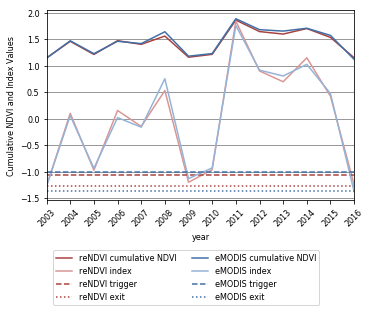

In [ ]:
#make time series graphs for cumulative NDVI, index values, and trigger and exit values for a UAI for short rains
smodissr2 = pd.DataFrame(smodissrdf.transpose(copy=True))
emodissr2 = pd.DataFrame(emodissrdf.transpose(copy=True))
uainumber = 166

yearlist=[2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016]
smodissr2[uainumber].loc[columnlist].plot(color='#a8423f', label='reNDVI cumulative NDVI', legend=True).set_facecolor('white')
smodissr2[uainumber].loc[columnlist1].plot(color='#d99694', label='reNDVI index', legend=True)
plt.axhline(y=smodissr2[uainumber].loc['trigger'], linestyle='dashed', label='reNDVI trigger', color='#a8423f')
plt.axhline(y=smodissr2[uainumber].loc['exit'], linestyle='dotted', label='reNDVI exit', color='#a8423f')
emodissr2[uainumber].loc[columnlist].plot(color='#416fa6', label='eMODIS cumulative NDVI', legend=True)
emodissr2[uainumber].loc[columnlist1].plot(color='#95b3d7', label='eMODIS index', legend=True)
plt.axhline(y=emodissr2[uainumber].loc['trigger'], linestyle='dashed', label='eMODIS trigger', color='#416fa6')
plt.axhline(y=emodissr2[uainumber].loc['exit'], linestyle='dotted', label='eMODIS exit', color='#416fa6')
plt.legend(loc='lower right', ncol=2, bbox_to_anchor=(.9,-.57))
plt.xlabel('year')
plt.ylabel('Cumulative NDVI and Index Values')
plt.xticks(np.arange(14), yearlist, rotation=45)
plt.grid(axis='y', color='gray')

fig = plt.gcf()
fig.set_size_inches(5.51181, 3.5)
plt.rcParams.update({'font.size': 8})

plt.savefig('timeseriesuai166sr.jpg', dpi=1000, frameon=True, bbox_inches='tight')
files.download('timeseriesuai166sr.jpg')

In [ ]:
print('short rains yearly payouts')
print(smodissrdf['payout2003'].astype(bool).sum())
print(emodissrdf['payout2003'].astype(bool).sum())

print(smodissrdf['payout2004'].astype(bool).sum())
print(emodissrdf['payout2004'].astype(bool).sum())

print(smodissrdf['payout2005'].astype(bool).sum())
print(emodissrdf['payout2005'].astype(bool).sum())

print(smodissrdf['payout2006'].astype(bool).sum())
print(emodissrdf['payout2006'].astype(bool).sum())

print(smodissrdf['payout2007'].astype(bool).sum())
print(emodissrdf['payout2007'].astype(bool).sum())

print(smodissrdf['payout2008'].astype(bool).sum())
print(emodissrdf['payout2008'].astype(bool).sum())

print(smodissrdf['payout2009'].astype(bool).sum())
print(emodissrdf['payout2009'].astype(bool).sum())

print(smodissrdf['payout2010'].astype(bool).sum())
print(emodissrdf['payout2010'].astype(bool).sum())

print(smodissrdf['payout2011'].astype(bool).sum())
print(emodissrdf['payout2011'].astype(bool).sum())

print(smodissrdf['payout2012'].astype(bool).sum())
print(emodissrdf['payout2012'].astype(bool).sum())

print(smodissrdf['payout2013'].astype(bool).sum())
print(emodissrdf['payout2013'].astype(bool).sum())

print(smodissrdf['payout2014'].astype(bool).sum())
print(emodissrdf['payout2014'].astype(bool).sum())

print(smodissrdf['payout2015'].astype(bool).sum())
print(emodissrdf['payout2015'].astype(bool).sum())

print(smodissrdf['payout2016'].astype(bool).sum())
print(emodissrdf['payout2016'].astype(bool).sum())



print('long rains yearly payouts')
print(smodislrdf['payout2003'].astype(bool).sum())
print(emodislrdf['payout2003'].astype(bool).sum())

print(smodislrdf['payout2004'].astype(bool).sum())
print(emodislrdf['payout2004'].astype(bool).sum())

print(smodislrdf['payout2005'].astype(bool).sum())
print(emodislrdf['payout2005'].astype(bool).sum())

print(smodislrdf['payout2006'].astype(bool).sum())
print(emodislrdf['payout2006'].astype(bool).sum())

print(smodislrdf['payout2007'].astype(bool).sum())
print(emodislrdf['payout2007'].astype(bool).sum())

print(smodislrdf['payout2008'].astype(bool).sum())
print(emodislrdf['payout2008'].astype(bool).sum())

print(smodislrdf['payout2009'].astype(bool).sum())
print(emodislrdf['payout2009'].astype(bool).sum())

print(smodislrdf['payout2010'].astype(bool).sum())
print(emodislrdf['payout2010'].astype(bool).sum())

print(smodislrdf['payout2011'].astype(bool).sum())
print(emodislrdf['payout2011'].astype(bool).sum())

print(smodislrdf['payout2012'].astype(bool).sum())
print(emodislrdf['payout2012'].astype(bool).sum())

print(smodislrdf['payout2013'].astype(bool).sum())
print(emodislrdf['payout2013'].astype(bool).sum())

print(smodislrdf['payout2014'].astype(bool).sum())
print(emodislrdf['payout2014'].astype(bool).sum())

print(smodislrdf['payout2015'].astype(bool).sum())
print(emodislrdf['payout2015'].astype(bool).sum())

print(smodislrdf['payout2016'].astype(bool).sum())
print(emodislrdf['payout2016'].astype(bool).sum())

short rains yearly payouts
43
47
7
14
136
121
8
5
8
15
13
10
54
46
101
104
0
0
3
7
9
12
6
4
0
0
128
131
long rains yearly payouts
8
18
33
32
26
35
34
33
2
6
47
36
122
103
0
0
138
133
35
32
1
1
19
24
42
43
9
20
